



**Problem statement**



To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Importing libraries**

In [46]:

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Load Train and Test data set

In [4]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Load using keras.preprocessing**

These images off disk using the helpful image_dataset_from_directory utility


Create a dataset

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                seed=123,
                                                                validation_split = 0.2,
                                                                image_size=(img_height, img_width),
                                                                batch_size=batch_size,
                                                                label_mode='int',
                                                                subset = 'training')

print(train_ds)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                              seed=123,
                                                              validation_split = 0.2,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size,
                                                              label_mode='int',
                                                              subset = 'validation')
print(val_ds)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data

create a code to visualize one instance of all the nine classes present in the dataset

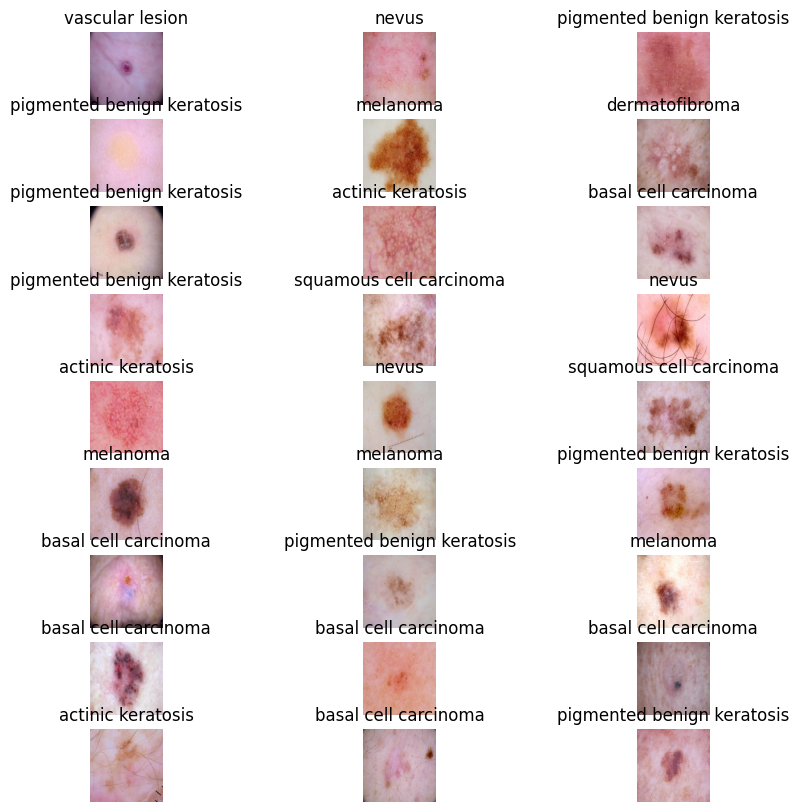

In [10]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
def plot_images(dataset, num_images=27):
  image_batch, label_batch = next(iter(dataset))
  plt.figure(figsize=(10, 10))
  for n in range(num_images):
    ax = plt.subplot(9, 3, n + 1)
    plt.imshow(image_batch[n].numpy().astype("uint8"))
    plt.title(class_names[label_batch[n]])
    plt.axis("off")

plot_images(train_ds)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

**Dataset.cache()**keeps the images in memory after they're loaded off disk during the first epoch.

**Dataset.prefetch()** overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Create the model**

Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [12]:
def create_cnn_model(input_shape = (180, 180, 3), num_classes = 9):
  model = models.Sequential([
      # Rescaling pixel values from [0,255] to [0,1]
      layers.Rescaling(1./255, input_shape=input_shape),
      # First convolution layer
      layers.Conv2D(32, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2)),
      # Second convolution layer
      layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2)),
      # Third convolution layer
      layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      layers.MaxPooling2D((2,2)),
      # Flatten 3D tensor to 1D vector
      layers.Flatten(),
      # Dense Layer (Fully connected layer)
      layers.Dense(128, activation='relu'),
      # Output layer
      layers.Dense(num_classes, activation='softmax')
  ])
  return model

model = create_cnn_model()

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model**

Choose an appropirate optimiser and loss function for model training

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 509s 4s/step - accuracy: 0.2213 - loss: 2.5752 - val_accuracy: 0.2752 - val_loss: 1.9670
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.3106 - loss: 1.9022 - val_accuracy: 0.4094 - val_loss: 1.7233
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.4484 - loss: 1.5906 - val_accuracy: 0.4944 - val_loss: 1.5341
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.4624 - loss: 1.5106 - val_accuracy: 0.4966 - val_loss: 1.4836
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.5222 - loss: 1.3430 - val_accuracy: 0.4877 - val_loss: 1.4635
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5457 - loss: 1.2544 - val_accuracy: 0.5213 - val_loss: 1.5303
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.5642 - loss: 1.2188 - val_accuracy: 0.5302 - val_loss: 1.4116
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.5827 - loss: 1.0930 - val_accuracy: 0.5190 - v

**Visualizing training results**

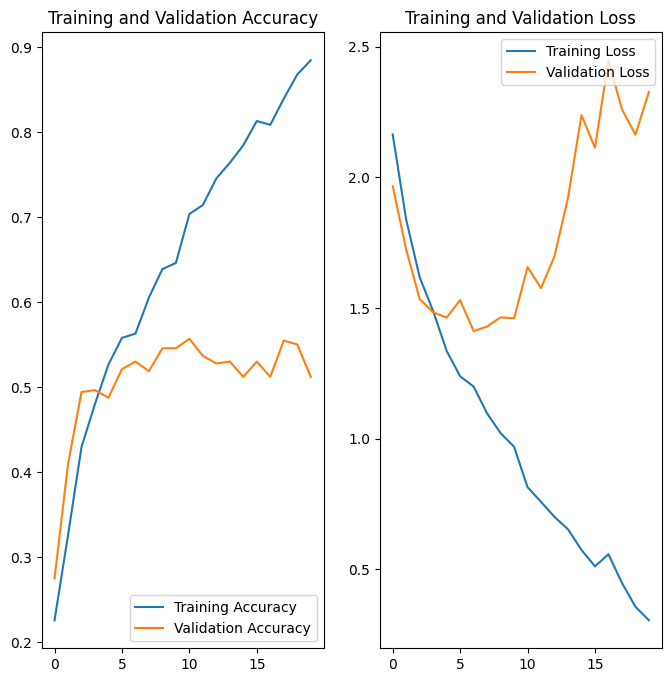

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**

From graph, we can clearly see there is a much gap between training accuracy and validation accuracy. Since training accuracy is higher and validation accuracy is lower its clear sign of overfitting.

In [17]:
data_augmentation = ImageDataGenerator(rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

In [18]:
augmented_train_ds = data_augmentation.flow_from_directory(data_dir_train,
                                                            seed=123,
                                                            target_size=(img_height, img_width),
                                                            batch_size=batch_size,
                                                            class_mode='sparse',
                                                            subset = 'training',
                                                            shuffle=True)

Found 2239 images belonging to 9 classes.


In [19]:
#Fitting model with augmented train ds
history = model.fit(augmented_train_ds,
                  validation_data=val_ds,
                  epochs=10,
                  batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.4206 - loss: 1.9416 - val_accuracy: 0.5481 - val_loss: 1.3824
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.5183 - loss: 1.3828 - val_accuracy: 0.5168 - val_loss: 1.3349
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 225s 3s/step - accuracy: 0.5194 - loss: 1.3462 - val_accuracy: 0.5884 - val_loss: 1.1955
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.5529 - loss: 1.2367 - val_accuracy: 0.5794 - val_loss: 1.1602
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.5540 - loss: 1.2108 - val_accuracy: 0.5481 - val_loss: 1.2337
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 226s 3s/step - accuracy: 0.5488 - loss: 1.2557 - val_accuracy: 0.5906 - val_loss: 1.1015
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.5831 - loss: 1.1499 - val_accuracy: 0.5996 - val_loss: 1.0895
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.5717 - loss: 1.1949 - val_accuracy: 0.6107 - v

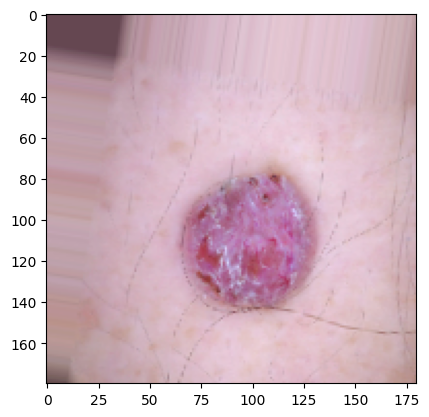

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
sample_image, _ = next(iter(augmented_train_ds))
plt.imshow(sample_image[0].astype('uint8'))
plt.show()

**Create the model, compile and train the model**

In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

def create_cnn_model_with_dropout(input_shape=(180, 180, 3), num_classes=9, dropout_rate=0.3):
    model = models.Sequential([
        # Rescaling the pixel values from [0, 255] to [0, 1]
        layers.Rescaling(1./255, input_shape=input_shape),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        #layers.Dropout(dropout_rate),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        #layers.Dropout(dropout_rate),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        #layers.Dropout(dropout_rate),

        # Flatten the 3D tensor to 1D vector for the fully connected layers
        layers.Flatten(),

        # Fully connected layer (Dense layer)
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),

        # Output layer with 9 units (one for each class), softmax activation for multi-class classification
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_cnn_model_with_dropout()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

**Compiling the model**

In [22]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Training the model**

In [23]:
## Your code goes here, note: train your model for 20 epochs
history_after_dropout = model.fit(augmented_train_ds,
                  validation_data=val_ds,
                  epochs=20,
                  batch_size=32)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.1945 - loss: 2.3006 - val_accuracy: 0.3177 - val_loss: 1.8496
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.3458 - loss: 1.8121 - val_accuracy: 0.4206 - val_loss: 1.6027
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.4319 - loss: 1.6174 - val_accuracy: 0.4966 - val_loss: 1.5463
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.4518 - loss: 1.5442 - val_accuracy: 0.5011 - val_loss: 1.4798
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.4546 - loss: 1.5609 - val_accuracy: 0.5280 - val_loss: 1.3883
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 219s 3s/step - accuracy: 0.4640 - loss: 1.5059 - val_accuracy: 0.4855 - val_loss: 1.4416
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.4875 - loss: 1.4373 - val_accuracy: 0.5481 - val_loss: 1.2856
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.5225 - loss: 1.3800 - val_accuracy: 0.5235 - v

Visualizing the results

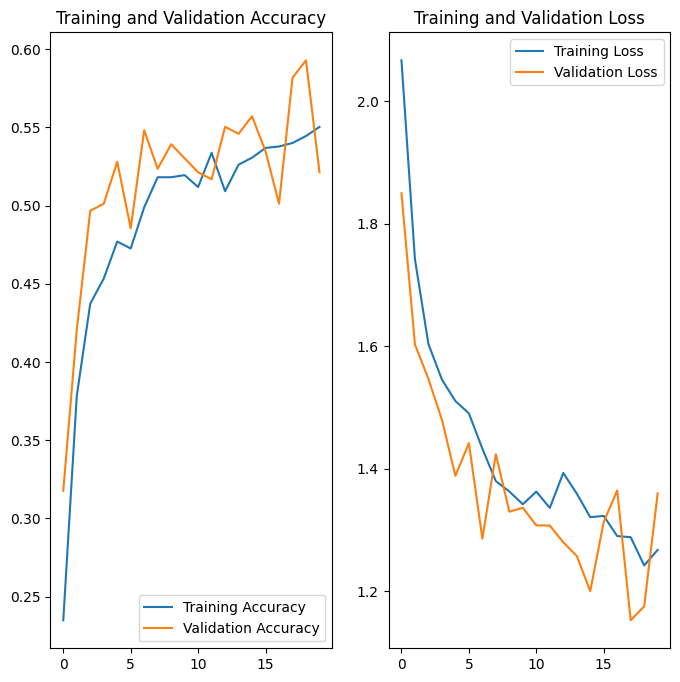

In [25]:
acc = history_after_dropout.history['accuracy']
val_acc = history_after_dropout.history['val_accuracy']

loss = history_after_dropout.history['loss']
val_loss = history_after_dropout.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?**

 we can see overfitting is reduced. but model is underperforming. There is a scope for imporoving performance.

**Todo: Find the distribution of classes in the training dataset.**

**Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.**

Class Counts:
Class actinic keratosis: 92 samples
Class basal cell carcinoma: 309 samples
Class dermatofibroma: 77 samples
Class melanoma: 352 samples
Class nevus: 277 samples
Class pigmented benign keratosis: 370 samples
Class seborrheic keratosis: 58 samples
Class squamous cell carcinoma: 142 samples
Class vascular lesion: 115 samples


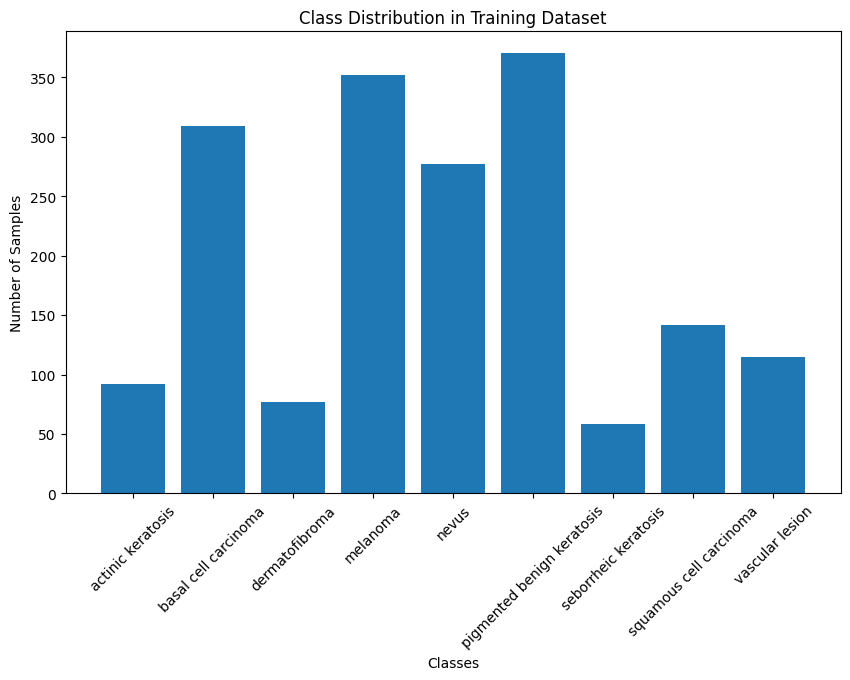

In [26]:
class_labels = []
for images, labels in train_ds:
    class_labels.extend(labels.numpy())  # Convert labels to numpy array and collect them

# Convert the list of labels to a numpy array
class_labels = np.array(class_labels)

# Count occurrences of each class using np.unique
class_counts = np.unique(class_labels, return_counts=True)

# Display class counts
print("Class Counts:")
for class_id, count in zip(class_counts[0], class_counts[1]):
    print(f"Class {class_names[class_id]}: {count} samples")

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_counts[0], class_counts[1], tick_label=[class_names[i] for i in class_counts[0]])
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.show()

**Todo: Write your findings here:**

 Which class has the least number of samples?

 Ans: seborrheic keratosis

 Which classes dominate the data in terms proportionate number of samples?

 Ans: Ans: pigmented benign keratosis


**Todo: Rectify the class imbalance**

**Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.**

In [27]:
!pip install Augmentor

In [29]:
#path_to_training_dataset="./CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_training_dataset = r"/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train"+"/"
print(os.path.exists(path_to_training_dataset))
import Augmentor
for i in class_names:
    print(path_to_training_dataset+"")
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

True
/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D0C6B320CD0>: 100%|██████████| 500/500 [00:20<00:00, 23.82 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0C6B64D0D0>: 100%|██████████| 500/500 [00:21<00:00, 23.12 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D0C6B4A9750>: 100%|██████████| 500/500 [00:24<00:00, 20.08 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7D0C6B4FE450>: 100%|██████████| 500/500 [01:27<00:00,  5.69 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0C6AE7D0D0>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0C6B530A10>: 100%|██████████| 500/500 [00:23<00:00, 21.24 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D0C6B515350>: 100%|██████████| 500/500 [00:47<00:00, 10.60 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0C6B659C90>: 100%|██████████| 500/500 [00:22<00:00, 22.53 Samples/s]


/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D0C6AEE9590>: 100%|██████████| 500/500 [00:23<00:00, 21.20 Samples/s]


In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Lets see the distribution of augmented data after adding new images to the original training data.**

In [31]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028499.jpg_081a960e-0b6c-4f2a-a6ab-bc0dcab6cd5a.jpg',
 '/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031659.jpg_7f6e4edd-972f-4dee-88eb-1ffc967a9f80.jpg',
 '/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031431.jpg_3f16b44d-720c-49f2-88ae-7a9188867ac7.jpg',
 '/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025471.jpg_b5a6880b-4bf7-402e-af90-76f6608ad645.jpg',
 '/content/drive/MyDrive/Data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell 

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
original_df = pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)

In [35]:
new_df['Label'].value_counts()

,count
Label,
squamous cell carcinoma,500
vascular lesion,500
seborrheic keratosis,500
pigmented benign keratosis,500
melanoma,500
nevus,500
dermatofibroma,500
basal cell carcinoma,500
actinic keratosis,500


**Train the model on the data created using Augmentor**

In [36]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [37]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train=path_to_training_dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Create a validation dataset**

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Create your model (make sure to include normalization)**

In [39]:
def create_cnn_model_with_normalize(input_shape=(180, 180, 3), num_classes=9, dropout_rate=0.3):
    model = models.Sequential([
        # Rescaling the pixel values from [0, 255] to [0, 1]
        layers.Rescaling(1./255, input_shape=input_shape),

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Flatten the 3D tensor to 1D vector for the fully connected layers
        layers.Flatten(),

        # Fully connected layer (Dense layer)
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        # Output layer with 9 units (one for each class), softmax activation for multi-class classification
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

model = create_cnn_model_with_normalize()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,905 (30.61 MB)

 Trainable params: 8,024,649 (30.61 MB)

 Non-trainable params: 256 (1.00 KB)

**Compile your model**

In [42]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Train your model**

In [43]:
epochs = 30
## Your code goes here, use 50 epochs.
history_after_new_images_added = model.fit(train_ds,
                  validation_data=val_ds,
                  epochs=20,
                  batch_size=32)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 498s 3s/step - accuracy: 0.2998 - loss: 1.9203 - val_accuracy: 0.2895 - val_loss: 5.4105
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.4488 - loss: 1.5003 - val_accuracy: 0.2777 - val_loss: 3.3702
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.4845 - loss: 1.4204 - val_accuracy: 0.4053 - val_loss: 1.7689
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 505s 3s/step - accuracy: 0.5042 - loss: 1.3595 - val_accuracy: 0.3474 - val_loss: 2.9403
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.5197 - loss: 1.3423 - val_accuracy: 0.4001 - val_loss: 2.3321
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 494s 3s/step - accuracy: 0.4828 - loss: 1.4112 - val_accuracy: 0.3964 - val_loss: 1.5741
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.4850 - loss: 1.3912 - val_accuracy: 0.3482 - val_loss: 2.1309
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.5098 - loss: 1.3440 - val_accu

**Visualize the model results**

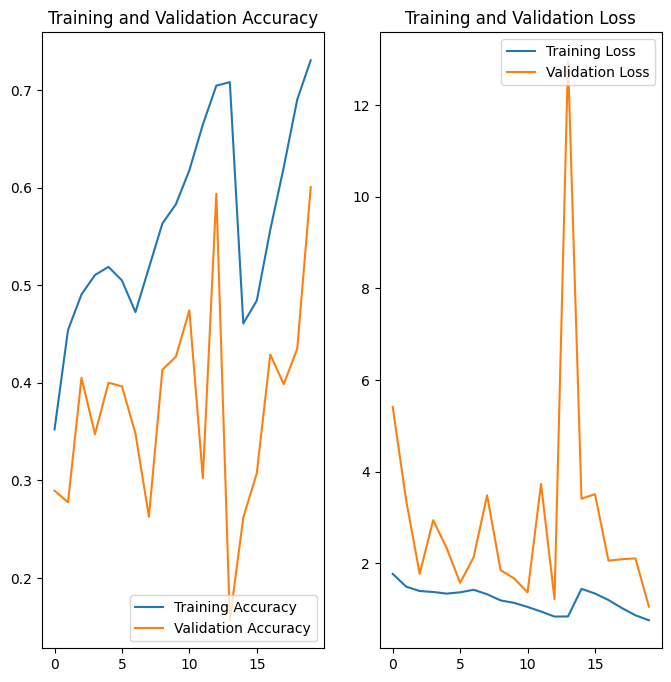

In [45]:
acc = history_after_new_images_added.history['accuracy']
val_acc = history_after_new_images_added.history['val_accuracy']

loss = history_after_new_images_added.history['loss']
val_loss = history_after_new_images_added.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?**

Validation loss is reduced, and Traning and Validation accuracy is improved.